# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW04] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит реализовать классический перцептрон, немного улчшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [2]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
from typing import NoReturn

In [3]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течение `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [247]:
class Perceptron:
    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения), 
        w[0] должен соответстовать константе, 
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.
        
        """

        self.w = None
        self.iterations = iterations
        self.unique = None
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает простой перцептрон. 
        Для этого сначала инициализирует веса перцептрона,
        а затем обновляет их в течение iterations итераций.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.
        
        """
        X_ = X.copy()
        X_ = np.hstack((np.ones((X_.shape[0], 1)), X_))
        self.w = np.zeros((X_.shape[1]))
        
        self.unique = np.unique(y)
        y_ = y.copy()
        y_[y_ == self.unique[0]] = -1
        y_[y_ == self.unique[1]] = 1
        
        for _ in range(self.iterations):
            pred = np.sign(X_ @ self.w).flatten()
            mismatches = np.where(pred != y_)[0]
            
            if not mismatches.size:
                break
                
            i = np.random.choice(mismatches)
            
            self.w = self.w + y_[i] * X_[i]
            
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.
        
        Return
        ------
        labels : np.ndarray
            Вектор индексов классов 
            (по одной метке для каждого элемента из X).
        
        """
        X_ = X.copy()
        X_ = np.hstack((np.ones((X_.shape[0], 1)), X_))
        pred = np.sign(X_ @ self.w).flatten()
        pred[pred == 0] = -1
        
        
        pred[pred == 1] = self.unique[1]
        pred[pred == -1] = self.unique[0]
        return pred

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

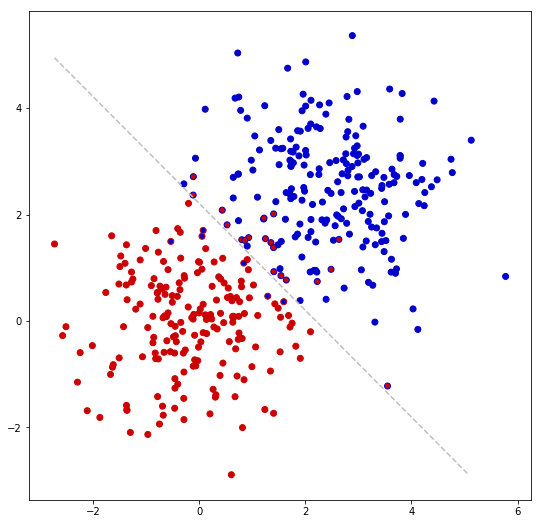

In [5]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

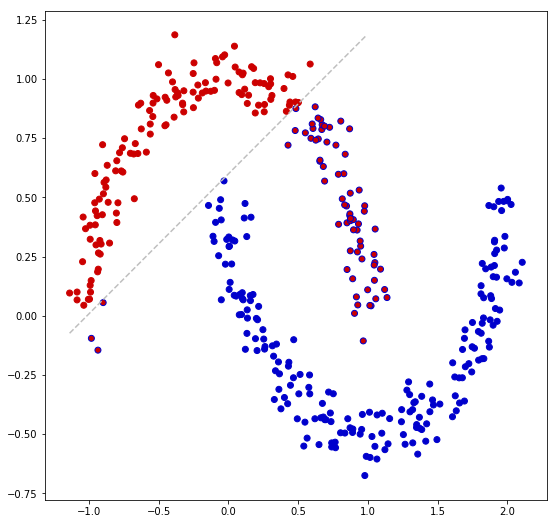

In [6]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течение `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [226]:
class PerceptronBest:

    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения), 
        w[0] должен соответстовать константе, 
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.
        
        """
        self.iterations = iterations
        self.w = None
        self.unique = None
        
        
    def _get_accuracy(self, y_pred: np.array, y_true: np.array):

        n = len(y_pred)
        classes = np.unique(list(y_pred) + list(y_true))
        accuracy = []
        for cl in classes[:1]:
            tp = sum(1 for i in range(n) if y_pred[i] == y_true[i] == cl)
            fp = sum(1 for i in range(n) if y_pred[i] == cl and y_true[i] != cl)
            tn = sum(1 for i in range(n) if y_pred[i] != cl and y_true[i] != cl)
            fn = sum(1 for i in range(n) if y_pred[i] != cl and y_true[i] == cl)

            if not (tp + fp + tn + fn):
                accuracy.append(None)
            else:
                accuracy.append((tp + tn) / (tp + fp + tn + fn))

        return np.array(accuracy)
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает перцептрон.

        Для этого сначала инициализирует веса перцептрона, 
        а затем обновляет их в течение iterations итераций.

        При этом в конце обучения оставляет веса, 
        при которых значение accuracy было наибольшим.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.
        
        """
        X_ = X.copy()
        X_ = np.hstack((np.ones((X_.shape[0], 1)), X_))
        self.w = np.zeros((X_.shape[1]))
        accuracy = 0
        self.unique = np.unique(y)
        y_ = y.copy()
        y_[y_ == self.unique[0]] = -1
        y_[y_ == self.unique[1]] = 1
        
        for _ in range(self.iterations):
            pred = np.sign(X_ @ self.w).flatten()
            acc = self._get_accuracy(pred, y_)[0]
            
            if acc > accuracy:
                accuracy = acc
                best_w = self.w.copy()
                
            mismatches = np.where(pred != y_)[0]
            
            if not mismatches.size:
                break
                
            i = np.random.choice(mismatches)
            
            self.w = self.w + y_[i] * X_[i]
        self.w = best_w
        
            
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.
        
        Return
        ------
        labels : np.ndarray
            Вектор индексов классов 
            (по одной метке для каждого элемента из X).
        
        """
        X_ = X.copy()
        X_ = np.hstack((np.ones((X_.shape[0], 1)), X_))
        pred = np.sign(X_ @ self.w).flatten()
        pred[pred == 0] = -1
        
        
        pred[pred == 1] = self.unique[1]
        pred[pred == -1] = self.unique[0]
        return pred

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

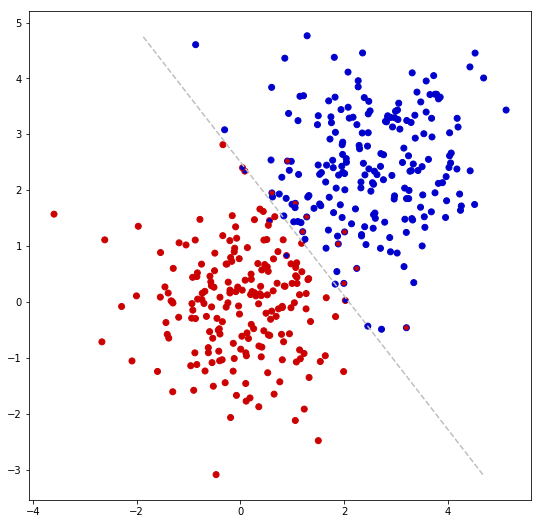

In [205]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

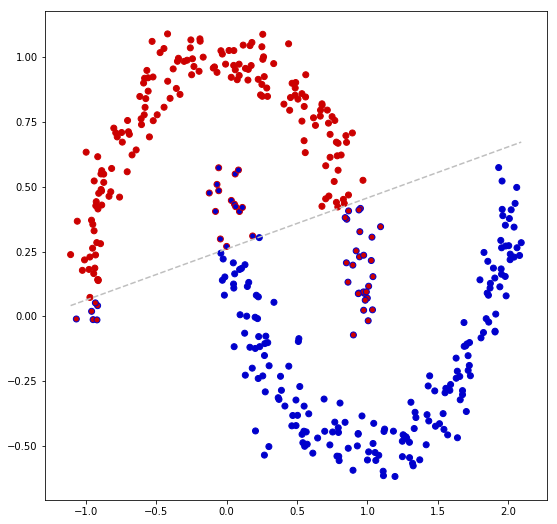

In [206]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [389]:
def transform_images(images: np.ndarray) -> np.ndarray:
    """
    Переводит каждое изображение в вектор из двух элементов.
        
    Parameters
    ----------
    images : np.ndarray
        Трехмерная матрица с черно-белыми изображениями.
        Её размерность: (n_images, image_height, image_width).
        Значения: 
            - среднее значение насыщенности пикселя в левом верхнем углу изображения
            - количество пикселей интенсивности < 1
    Return
    ------
    np.ndarray
        Двумерная матрица с преобразованными изображениями.
        Её размерность: (n_images, 2).
    """
    def upper_left_mean(image):
        return np.mean(image[:4, :4])

    
    def intensity(image):
        return np.count_nonzero(image < 1)
        
    sym = np.array([[upper_left_mean(image)] for image in images])
    intens = np.array([[intensity(image)] for image in images])
    return np.concatenate((sym, intens), axis=1)

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

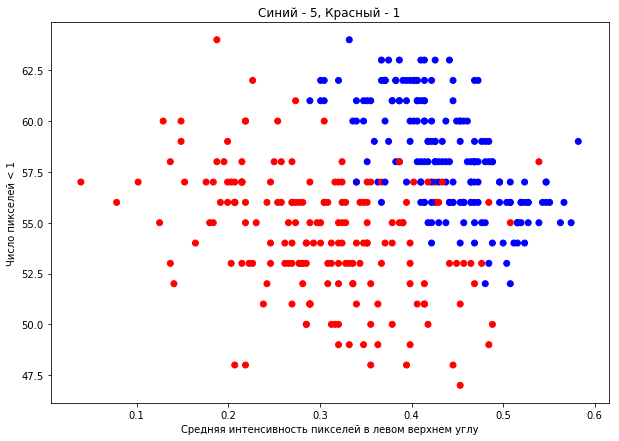

In [397]:
imgs, lab = get_digits()
x, y = list(zip(*imgs))

plt.figure(figsize=(10, 7))

colors = np.array(['blue', 'red'])
lab[lab == 5] = 0
plt.scatter(x, y, c=colors[lab])
plt.xlabel("Средняя интенсивность пикселей в левом верхнем углу")
plt.ylabel("Число пикселей < 1")
plt.title("Синий - 5, Красный - 1")
plt.show()

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Оценка за это задание выставляется следующим образом:
1. 1 балл - что-то обучается, картинки рисуются
2. 2 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 80%
3. 4 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 90%

__Обратите внимание, что перцептрон детерминирован, а выборка должна разбиваться без перемешивания__

In [398]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [399]:
def normalise(X_train, X_test):
    maxs = np.amax(X_train, axis=0)
    mins = np.amin(X_train, axis=0)
    for j in range(X_train.shape[1]):
        for i in range(X_train.shape[0]):
            X_train[i][j] = (X_train[i][j] - mins[j]) / (maxs[j] - mins[j])
    for j in range(X_test.shape[1]):
        for i in range(X_test.shape[0]):
            X_test[i][j] = (X_test[i][j] - mins[j]) / (maxs[j] - mins[j])
    
    return X_train, X_test

In [400]:
X_train, X_test = normalise(X_train, X_test)

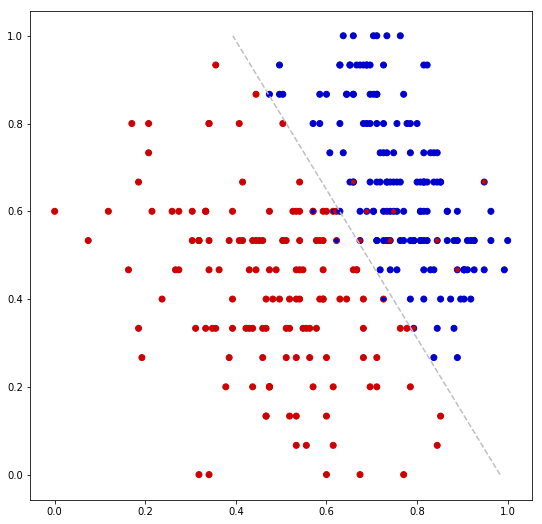

Accuracy: 0.958904109589041


In [401]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

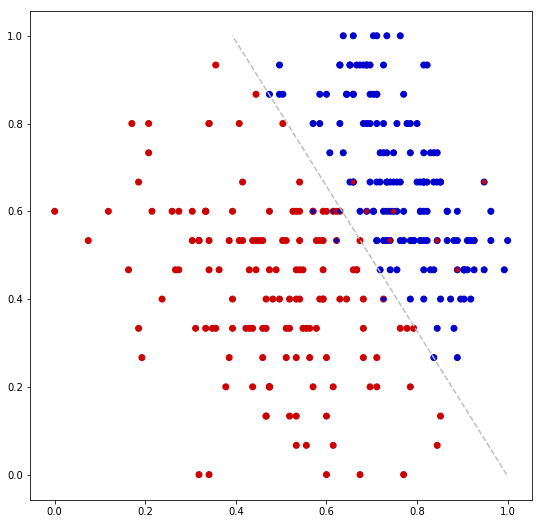

Accuracy: 0.9452054794520548


In [402]:
c = PerceptronBest(iterations=10000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [403]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.5110868747067216


In [405]:
%%time
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=1000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.5248781629400963
CPU times: user 1min 30s, sys: 231 ms, total: 1min 30s
Wall time: 1min 32s
